Notes from [Introduction to Synthetic Aperture Radar Using Python and MATLAB](https://ieeexplore.ieee.org/document/9893146).

# Polar Format Algorithm

Given that data is collected with constant range and varying azimuths $\theta_n$), the signal's wavenumber space is given by
$$ k_x = k * \cos(\theta_n) \text{\;\;(rad/m)} $$
$$ k_y = k * \sin(\theta_n) \text{\;\;(rad/m)} $$
where
$$ k = \frac{2\pi}{\lambda} = \frac{2\pi}{c}[f_0 + \beta(t-t_0)] \text{\;\;(rad/m)}$$
The signal data can then be interpolated onto the wavenumber grid.<br>

<img src='imgs/polar_raster.png' width=700 height=700 style='margin-left:auto; margin-right:auto;' />

We can then take a 2-D Inverse Fourier Transform to reconstruct the image
$$ s(x, y) = \int_{-\infty}^{\infty}\int_{-\infty}^{\infty}S(k_x x, k_y y)e^{i(k_x x + k_y y)}dk_x dk_y $$
and in discrete form
$$ s(x, y) = \sum_{m=1}^{M}\sum_{n=1}^{N}S(k_x^{m, n} x, k_y^{m, n} y)e^{i(k_x x + k_y y)} $$
This can be further broken down into
$$ s(x, y) = \sum_{n=1}^{N}[\sum_{m=1}^{M}S(k_x^{m} x, k_y^{n} y)e^{ik_x^m x}]e^{ik_y^n y} $$
It is important to note that this relies on the assumtion that the wave is planar and ignores phase errors. Further post-processing is generally required to produce useful images.

### Examples
#### Point Target

In [24]:
from sys import float_info

import numpy as np
import scipy
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.fft import ifft, fft, fftshift, ifftshift, fftfreq
from scipy.fft import ifft2, fft2
from scipy.constants import pi, c

In [25]:
from point_target import PointTargetKSpace

In [26]:
bandwidth       = 300e6
start_frequency = 5e9
range_to_center = 1000

x_target_pos = [-10, 0, 10]
y_target_pos = [10, 0, -10]
target_rcs   = [10, 10, 10]

image_dimensions = (100, 100)
image_bins       = (500, 500)
azimuth_span     = (-3, 3)

In [27]:
target = PointTargetKSpace(
    range_to_center,
    x_target_pos,
    y_target_pos,
    target_rcs,
    image_dimensions,
    image_bins,
    azimuth_span,
    start_frequency,
    bandwidth
)

In [28]:
fft_length = image_bins[0]

In [29]:
k = 2 * pi / target.wavelength

In [30]:
start_az = np.radians(0)
end_az = np.radians(45)

sensor_az = []
i = 0
index = []
for az in target.azimuths:
    if az >= start_az and az <= end_az:
        index.append(i)
        sensor_az.append(az)
        i += 1
signal = target.signal[:, index]

In [31]:
k_x = target.kx[:, index]
k_y = target.ky[:, index]

In [32]:
kx = np.linspace(np.min(k_x), np.max(k_x), dtype=complex)
ky = np.linspace(np.min(k_y), np.max(k_y), dtype=complex)
kx_grid, ky_grid = np.meshgrid(kx, ky)

In [33]:
signal_interp = scipy.interpolate.griddata((k_x.ravel(), k_y.ravel()), signal.ravel(), (kx_grid, ky_grid), method='linear', fill_value=(0+0j))

In [34]:
img = fftshift(fftshift(ifft2(signal_interp, (fft_length, fft_length)), 0), 1)

In [35]:
norm = 10 * np.log10(np.abs(img) / np.max(np.abs(img)))

In [36]:
freq_step_x = c / (2 * pi) * (kx_grid[0,1] - kx_grid[0,0])
range_extent_x = c / (2 * freq_step_x)
freq_step_y = c / (2 * pi) * (ky_grid[1,0] - ky_grid[0,0])
range_extent_y = c / (2 * freq_step_y)

In [37]:
x_rng = np.linspace(-0.5 * range_extent_x, 0.5 * range_extent_x, fft_length)
y_rng = np.linspace(-0.5 * range_extent_y, 0.5 * range_extent_y, fft_length)

(-15.0, 15.0)

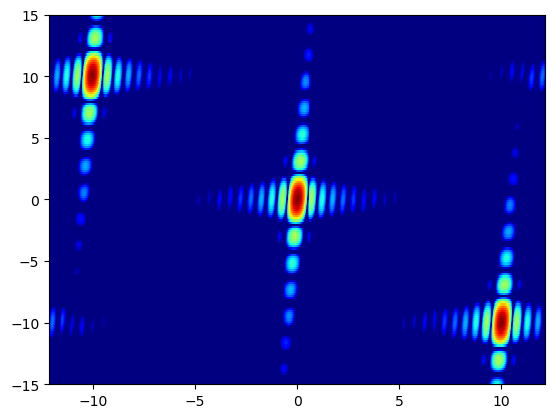

In [38]:
plt.pcolor(x_rng, y_rng, norm, cmap='jet', vmin=-15)
plt.ylim([-15, 15])

#### Backhoe
Already interpolated into a grid in k-space? Lots of phase error.

In [148]:
data = loadmat("./sample_data/backhoe_el000_az350to100.mat")
vv = np.squeeze(data['VV'])
hh = np.squeeze(data['HH'])
hv = np.squeeze(data['HV'])
freqs   = np.squeeze(data['FGHz']) * 1e+9

In [149]:
fft_length = 500
num_freqs = 500

In [150]:
signal = np.squeeze(vv[0:num_freqs]) + np.squeeze(hh[0:num_freqs]) + np.squeeze(hv[0:num_freqs])

In [151]:
img = fftshift(fftshift(ifft2(signal, (fft_length, fft_length)), 0), 1).transpose()

In [152]:
norm = 20 * np.log10(np.abs(img) / np.max(np.abs(img)))

In [153]:
freq_step_x = freqs[1] - freqs[0]
range_extent_x = c / (2 * freq_step_x)
freq_step_y = freqs[1] - freqs[0]
range_extent_y = c / (2 * freq_step_y)

In [154]:
x_rng = np.linspace(-0.5 * range_extent_x, 0.5 * range_extent_x, img.shape[1])
y_rng = np.linspace(-0.5 * range_extent_y, 0.5 * range_extent_y, img.shape[0])

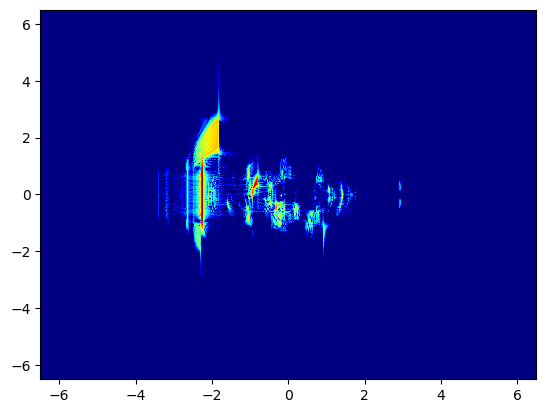

In [155]:
plt.pcolor(x_rng, y_rng, norm, cmap='jet', vmin=-35, vmax=0)